In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

import tinyDA as tda

In [2]:
b = 1
m = 2
x = np.linspace(0,1)
y_pure = b + m*x

sigma = 0.1
y = y_pure + np.random.normal(scale=sigma, size=x.shape[0])

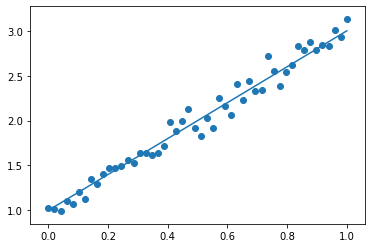

In [3]:
plt.plot(x, y_pure)
plt.scatter(x, y)
plt.show()

In [4]:
mean_prior = np.zeros(2)
cov_prior = np.eye(2)
cov_likelihood = sigma**2*np.eye(x.shape[0])

my_prior = multivariate_normal(mean_prior, cov_prior)
my_loglike_coarse = tda.AdaptiveLogLike(y, cov_likelihood)
my_loglike_fine = tda.LogLike(y, cov_likelihood)

In [5]:
class MyCoarseLinkFactory(tda.LinkFactory):
    def evaluate_model(self, parameters):
        output = parameters[0] + parameters[1]*x + np.random.normal(scale=0.01, size=x.size)
        qoi = None
        return output, qoi

In [6]:
class MyFineLinkFactory(tda.LinkFactory):
    def evaluate_model(self, parameters):
        output = parameters[0] + parameters[1]*x
        qoi = None
        return output, qoi

In [7]:
my_link_factory_coarse = MyCoarseLinkFactory(my_prior, my_loglike_coarse)
my_link_factory_fine = MyFineLinkFactory(my_prior, my_loglike_fine)

my_link_factories = [my_link_factory_coarse, my_link_factory_fine]

In [8]:
#rwmh_cov = np.eye(2)
#rmwh_scaling = 0.1
#rwmh_adaptive = True
#my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

#pcn_scaling = 0.1
#pcn_adaptive = True
#my_proposal = tda.CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

am_cov = np.eye(2)
am_t0 = 2000
am_sd = 1
am_epsilon = 1e-6
my_proposal = tda.AdaptiveMetropolis(C0=am_cov, t0=am_t0, sd=am_sd, epsilon=am_epsilon)

In [9]:
my_chain = tda.sample(my_link_factories, my_proposal, iterations=1200, n_chains=2, subsampling_rate=10, adaptive_error_model='state-independent')

Sampling 2 chains in parallel


2022-03-10 12:26:37,421	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8266
(pid=190043) /home/mikkel/.local/lib/python3.8/site-packages/tinyDA/proposal.py:223: RuntimeWarning: overflow encountered in exp
(pid=190043)   return np.exp(proposal_link.posterior - previous_link.posterior)
(pid=190044) /home/mikkel/.local/lib/python3.8/site-packages/tinyDA/proposal.py:223: RuntimeWarning: overflow encountered in exp
(pid=190044)   return np.exp(proposal_link.posterior - previous_link.posterior)


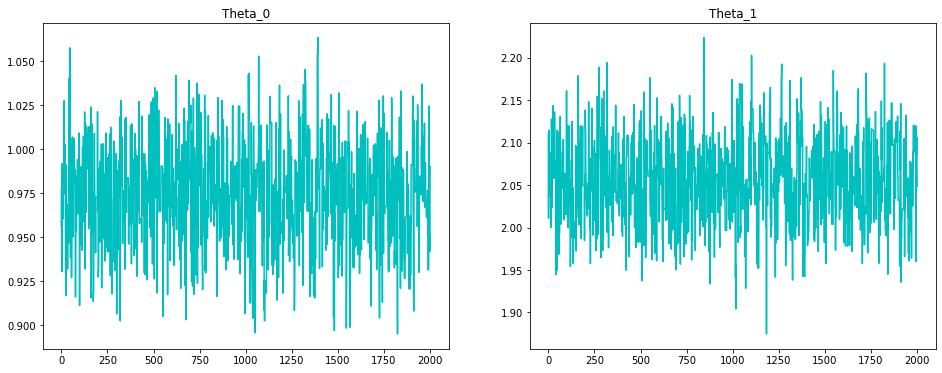

In [10]:
burnin = 200
samples_fine = tda.get_samples(my_chain, burnin=burnin)
tda.plot_samples(samples_fine)

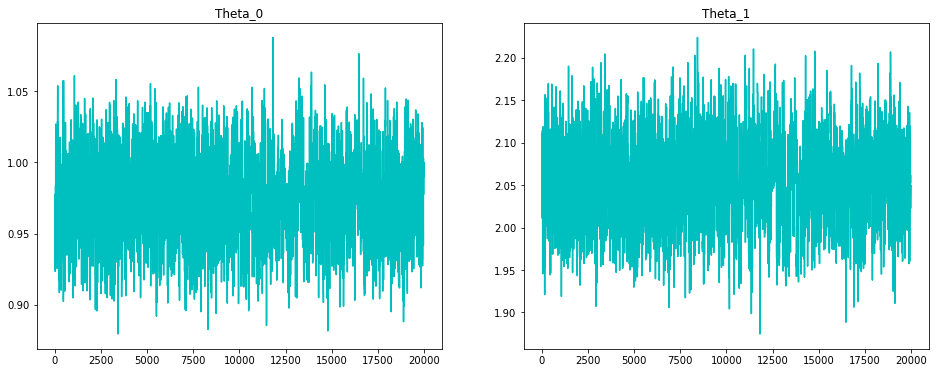

In [11]:
samples_coarse = tda.get_samples(my_chain, level='coarse', burnin=burnin*10)
tda.plot_samples(samples_coarse)

In [15]:
tda.compute_R_hat(samples_fine)

array([1.00408984, 1.00340303])

In [16]:
tda.compute_ESS(samples_fine)

array([588.17751958, 543.19925342])